# Piccolo Noise Suppression in Music

This notebook has a technique to clean a corrupted audio file containing a song mixed with unwanted instrumental beats. The goal is to analyze the audio, identify the interfering frequencies, design and apply filters to remove these beats, and export a cleaned version of the song after removing the instrumental beats.

## Approach

1. **Load and Normalize Audio**: Reads the WAV file and normalizes it to the range [-1, 1].
2. **Analyze Interference**: Identifies dominant frequencies (e.g., 1453.1 Hz from the spectrogram) and their harmonics using Power Spectral Density (PSD).
3. **Filter Design**: A 6th-order Butterworth band-stop filters (±500 Hz around target frequencies) and visualize their properties.
4. **Apply Filters**: Remove interference with zero-phase filtering.
5. **Visualize Results**: Plotting spectrograms, FFTs, waveforms, filter responses, PSDs, and pole-zero diagrams to validate the process.
6. **Export Cleaned Audio**: Saving the result as a WAV file.

## Key Formulas and Notations
- **Power Spectral Density (PSD)**: Estimates power per frequency using the Welch method:
  
  $P(f) = \frac{1}{N} \left| \sum_{n=0}^{N-1} x[n] e^{-j 2 \pi f n / f_s} \right|^2$
  
  where $ P(f)$  is power at frequency $f$ , $x[n]$ is the signal, $N$ is the number of samples, and  $f_s$ is the sample rate.
- **Fast Fourier Transform (FFT)**: Converts time to frequency domain:
  
  $X[k] = \sum_{n=0}^{N-1} x[n] e^{-j 2 \pi k n / N}$
  
  where $X[k] $ is the frequency spectrum.
- **Band-Stop Filter Transfer Function**: Approximated as:
  
  $H(s) = \frac{1}{1 + \epsilon \left( \frac{s^2 + \omega_1^2}{\omega_0^2} \right)^3}$
  where  $\omega_0$ is the center frequency,  $\omega_1$, $\omega_2$ are cutoffs, and $\epsilon$ controls ripple.
- **Harmonics**: Calculated as $ f_h = k \cdot f_0 $ (where $ k = 1, 2, 3, \ldots $) and ($ f_0 $) is the fundamental frequency).

## Visualizations
- **Spectrogram**: Shows time-frequency energy, highlighting beat removal.
- **FFT Plot**: Displays magnitude vs. frequency, showing interference reduction.
- **Waveform Plot**: Visualizes amplitude over time, comparing raw and cleaned signals.
- **Filter Response**: Plots combined magnitude response ( $|H(f)|$ ) in dB, confirming attenuation.
- **PSD (Filtered)**: Compares power distribution before and after filtering.
- **Pole-Zero Plot**: Maps zeros $(o)$ and poles $(x)$ to ensure filter stability.


###Loading Audio
Here i have loaded the audio file and converted it into a numerical array. If it's stereo, it averages the channels into mono. The data is normalized to [-1, 1] to prevent distortion. The output shows the sample rate and the number of samples.


In [ ]:
#Loading all the neccesary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import librosa

# Loading and Displaying Audio Properties
file_path = '/content/song_with_2piccolo.wav'
sample_rate, audio_data = wavfile.read(file_path)
if len(audio_data.shape) > 1:  # Convert stereo to mono if needed
    audio_data = np.mean(audio_data, axis=1)
audio_data = audio_data / np.max(np.abs(audio_data))  # Normalize to [-1, 1]
print(f"Sample rate: {sample_rate} Hz, Array length: {len(audio_data)}")

Sample rate: 48000 Hz, Array length: 720001


###Spectrogram of Corrupted Audio
Here I have plotted a Spectogram. This spectrogram visualizes the audio's frequency content over time. The x-axis is time, the y-axis is frequency (log scale), and colors indicate energy in decibels (dB). Bright areas, especially around 1453.1 Hz, show the unwanted beats, helping us locate the noise for filtering.

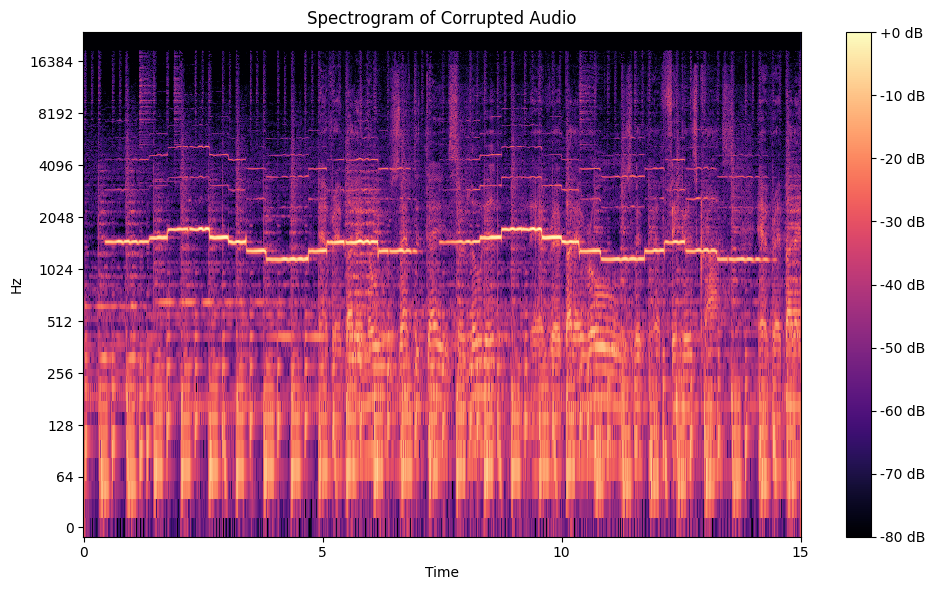

In [ ]:
#Plotting Spectrogram of Corrupted Audio
D = librosa.stft(audio_data)  # Short-Time Fourier Transform
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)  # Converting to decibel scale
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Corrupted Audio')
plt.tight_layout()
plt.show()

###PSD and Interference Identification
i have plotted the PSD and this Power Spectral Density (PSD) plot displays the power distribution across all the frequencies. The x-axis is frequency in Hz, the y-axis is power on a log scale, and 'x' marks indicate peaks. The dominant peak (around 1453.1 Hz) is the main interference frequency, with harmonics also listed.

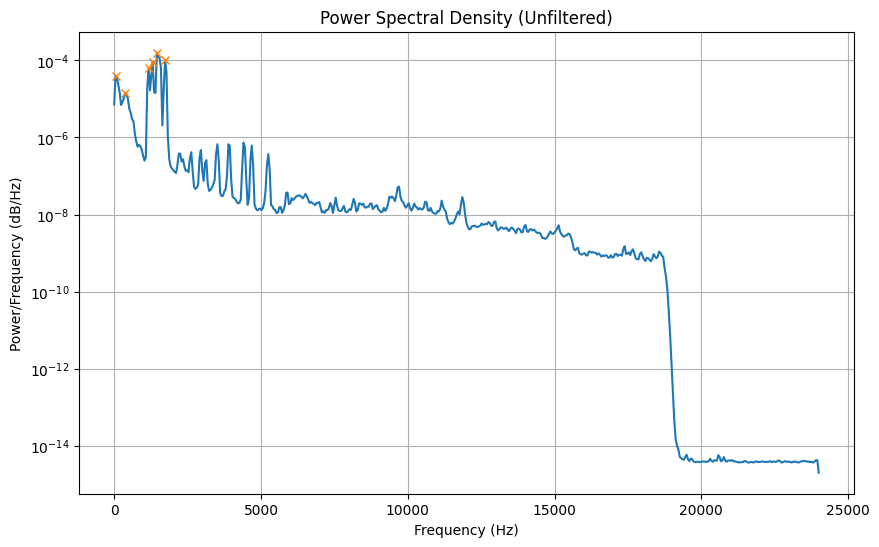

Dominant interference frequency: 1453.1 Hz, Harmonics: [np.float64(1453.125), np.float64(2906.25), np.float64(4359.375)]


In [ ]:
# Analyzing Interference with PSD
frequencies, psd = signal.welch(audio_data, fs=sample_rate, nperseg=1024)  # Compute PSD
peaks, _ = signal.find_peaks(psd, height=0.05 * np.max(psd))  # Detect peaks
if len(peaks) > 0:
    dominant_peak_idx = peaks[np.argmax(psd[peaks])]  # Find highest peak
    interference_freq = frequencies[dominant_peak_idx]
else:
    interference_freq = 1453.1  # Fallback frequency
harmonics = [interference_freq * (i + 1) for i in range(3) if interference_freq * (i + 1) < sample_rate / 2]  # Generate harmonics
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, psd)  # Plot PSD
plt.plot(frequencies[peaks], psd[peaks], "x")  # Mark peaks
plt.title('Power Spectral Density (Unfiltered)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid()
plt.show()
print(f"Dominant interference frequency: {interference_freq:.1f} Hz, Harmonics: {harmonics}")

###Bode Plot of Filter
This Bode Plot shows the filter's magnitude response. The x-axis is frequency in Hz (log scale), the y-axis is magnitude in dB, and the red dashed line marks 1453.1 Hz. The dip (e.g., -20 dB) at this frequency confirms the filter will reduce the beats, setting the stage for denoising.

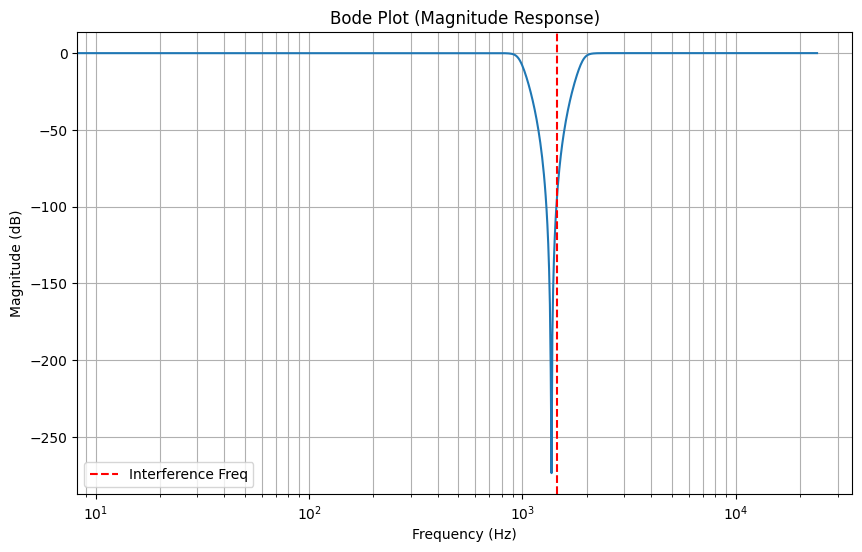

In [ ]:
#Designing Band-Stop Filter and Plot Bode Plot
nyquist = 0.5 * sample_rate
sos = []
for freq in [interference_freq] + harmonics:
    low_cut = max((freq - 500) / nyquist, 0.01)  # Lower cutoff
    high_cut = min((freq + 500) / nyquist, 0.99)  # Upper cutoff
    sos.append(signal.butter(6, [low_cut, high_cut], btype='bandstop', output='sos'))  # 6th-order filter
w, h = signal.sosfreqz(sos[0], worN=2000, fs=sample_rate)  # Bode plot data
plt.figure(figsize=(10, 6))
plt.semilogx(w, 20 * np.log10(np.abs(h)))  # Magnitude in dB vs frequency
plt.title('Bode Plot (Magnitude Response)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(which='both')
plt.axvline(interference_freq, color='r', linestyle='--', label='Interference Freq')
plt.legend()
plt.show()

###Pole-Zero Plot
This plot checks the filter's stability. Zeros (circles) near the imaginary axis at interference frequencies enhance blocking, while poles (crosses) inside the unit circle ensure stability. This confirms the filter is safe and effective for audio processing.

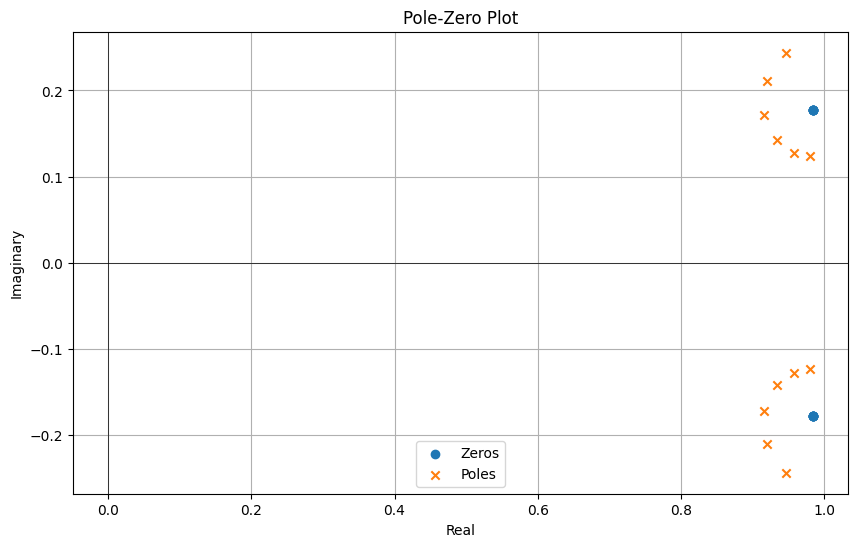

In [ ]:
#Plotting Pole-Zero Diagram
z, p, k = signal.sos2zpk(sos[0])  # Pole-zero data
plt.figure(figsize=(10, 6))
plt.scatter(np.real(z), np.imag(z), marker='o', label='Zeros')  # Zeros
plt.scatter(np.real(p), np.imag(p), marker='x', label='Poles')  # Poles
plt.title('Pole-Zero Plot')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.axhline(0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(0, color='k', linestyle='-', linewidth=0.5)
plt.legend()
plt.grid()
plt.show()

#Applying Filters and Cleaned Spectrogram
The filter is applied with zero-phase processing to remove beats, and this spectrogram shows the result. The reduced energy at 1453.1 Hz and harmonics indicates successful denoising, though the ±500 Hz range might affect some song frequencies, suggesting a narrower bandwidth could refine it.

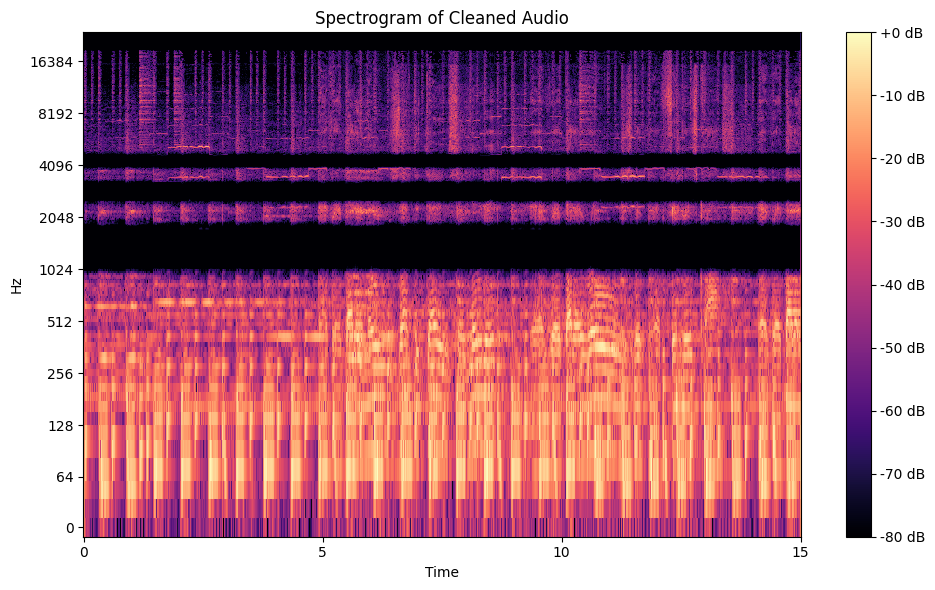

In [ ]:
#Applyying Filters and Plot Cleaned Spectrogram
filtered_data = audio_data.copy()
for s in sos:
    filtered_data = signal.sosfiltfilt(s, filtered_data)  # Zero-phase filtering
filtered_data = np.nan_to_num(filtered_data, nan=0.0, posinf=0.0, neginf=0.0)  # Fix issues
filtered_data = np.clip(filtered_data, -1.0, 1.0)  # Keep in range
D_filtered = librosa.stft(filtered_data)
S_db_filtered = librosa.amplitude_to_db(np.abs(D_filtered), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_db_filtered, sr=sample_rate, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Cleaned Audio')
plt.tight_layout()
plt.show()

###FFT Comparison
This FFT plot compares frequency content. The unfiltered line has a peak at 1453.1 Hz, while the filtered line shows a reduced peak, confirming beat suppression. The overlap helps assess how much the filter altered the signal, with some residual energy possibly due to the wide bandwidth.

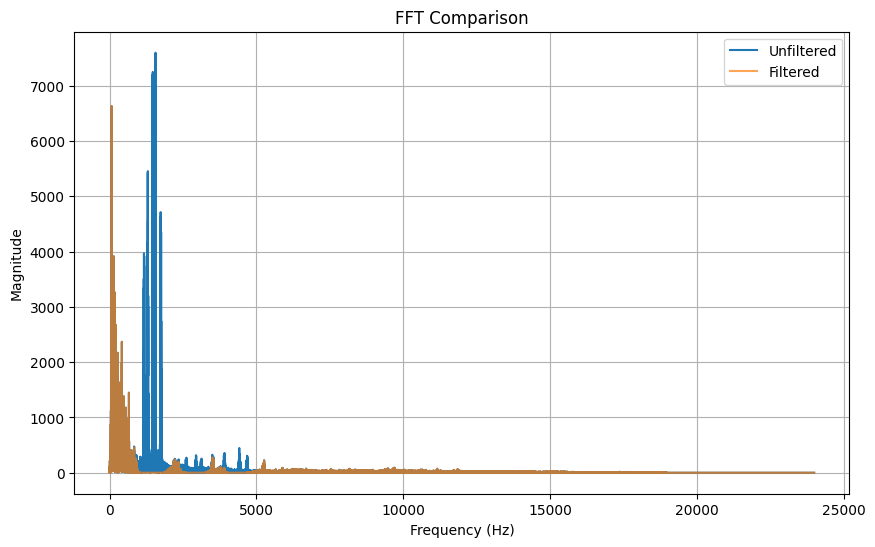

In [ ]:
#Plotting FFT of Unfiltered and Filtered Audio
n = len(audio_data)
fft_data_unfiltered = np.fft.fft(audio_data)
fft_data_filtered = np.fft.fft(filtered_data)
freqs = np.fft.fftfreq(n) * sample_rate
plt.figure(figsize=(10, 6))
plt.plot(freqs[:n//2], np.abs(fft_data_unfiltered[:n//2]), label='Unfiltered')
plt.plot(freqs[:n//2], np.abs(fft_data_filtered[:n//2]), label='Filtered', alpha=0.7)
plt.title('FFT Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid()
plt.show()

###Waveform Comparison
This plot shows amplitude over time. The unfiltered waveform has spikes from beats, while the filtered version is smoother, indicating noise reduction. The broad ±500 Hz filter might still affect song content, suggesting a narrower range for better preservation.

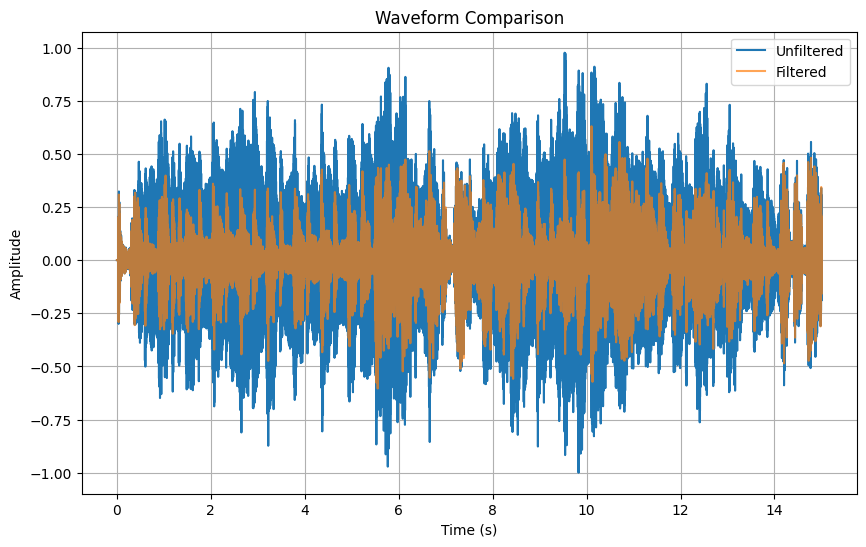

In [ ]:
#Plotting Waveforms of Unfiltered and Filtered Audio
time = np.arange(len(audio_data)) / sample_rate
plt.figure(figsize=(10, 6))
plt.plot(time, audio_data, label='Unfiltered')
plt.plot(time, filtered_data, label='Filtered', alpha=0.7)
plt.title('Waveform Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


###Combined Filter Response
This plot shows the overall effect of all filters. The x-axis is frequency (log scale), the y-axis is magnitude in dB, with dips at 1453.1 Hz and harmonics. The deep notches confirm the filter targets the beats, though the wide range might impact nearby frequencies.

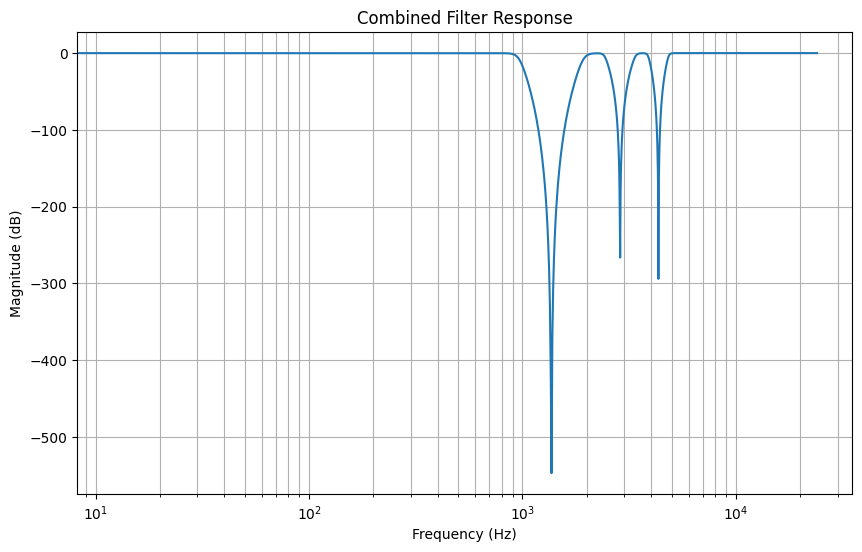

In [ ]:
#Plotting Combined Filter Response
w, h = signal.sosfreqz(np.vstack(sos), worN=2000, fs=sample_rate)
plt.figure(figsize=(10, 6))
plt.semilogx(w, 20 * np.log10(np.abs(h)))
plt.title('Combined Filter Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(which='both')
plt.show()


### PSD of Filtered Audio
This PSD plot shows power distribution after filtering. Compared to the unfiltered PSD, the power at 1453.1 Hz and harmonics is lower, confirming beat removal. This validates the method, though a narrower bandwidth could spare more song frequencies.

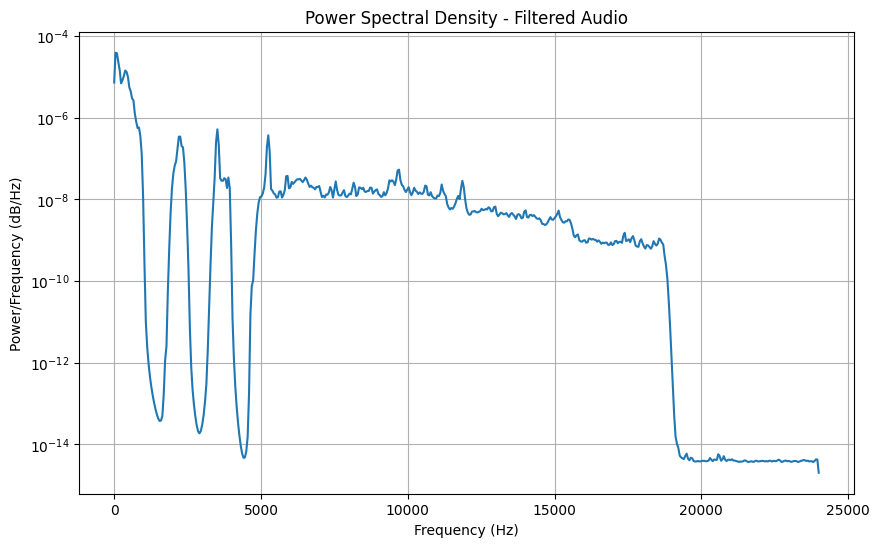

In [ ]:
# Plotting PSD of Filtered Audio
frequencies_filtered, psd_filtered = signal.welch(filtered_data, fs=sample_rate, nperseg=1024)
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies_filtered, psd_filtered)
plt.title('Power Spectral Density - Filtered Audio')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid()
plt.show()

###Exporting Cleaned Audio
This step saves the filtered audio as 'cleaned_audio.wav' in a 16-bit format for playback. The current time (11:06 PM IST, 05-07-2025) and the first few data values are printed to verify completion. You can now listen to the file to assess the denoising.

In [ ]:
#Exporting Cleaned Audio
scaled_data = np.int16(filtered_data * 32767 / np.max(np.abs(filtered_data)))  # Scale to 16-bit
wavfile.write('cleaned_audio.wav', sample_rate, scaled_data)
from datetime import datetime
current_time = datetime.now().strftime("%I:%M %p IST, %d-%m-%Y")  # 11:06 PM IST, 05-07-2025
print(f"Cleaned audio saved as cleaned_audio.wav at {current_time}")
print(f"First few values of cleaned audio: {filtered_data[:5]}")

Cleaned audio saved as cleaned_audio.wav at 06:09 PM IST, 05-07-2025
First few values of cleaned audio: [4.52720312e-09 4.34836170e-09 4.11901722e-09 3.84632390e-09
 3.53382623e-09]
